In [ ]:
from flow_package import data_preprocessing
from flow_package.binary_flow_env import BinaryFlowEnv, InputType
import os
import pandas as pd
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

TRAIN_PATH = os.path.abspath("../../dataset/cicids2017/train.csv")
TEST_PATH = os.path.abspath("../../dataset/cicids2017/test.csv")

train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

データの前処理を開始します。
One-Hot Encodingが完了しました。
正規化が完了しました。
データのバランス調整が完了しました。


In [ ]:
import glob

In [ ]:
data_type = {
    "Protocol": "category",
    "Label": "category",
}

df = pd.DataFrame()

paths = glob.glob("./raw_after_filtered/cicids2017/data/*.csv")

for path in paths:
    df_tmp = pd.read_csv(path, dtype=data_type)
    df = pd.concat([df, df_tmp], axis=0)

df = df.dropna(how="any").dropna(how="all", axis=1)

In [ ]:
labels = []

with open("./raw_after_filtered/cicids2017/label_list.txt") as f:
    for line in f:
        labels.append(line.strip())

In [ ]:
df_normal = df[df["Number Label"] == 0]
df_attack = df[df["Number Label"] != 0]

print(f"attack: {len(df_attack)}")

attack: 556556


In [ ]:
ohe_labels = []
with open("./raw_after_filtered/cicids2017/ohe_labels.txt") as f:
    for line in f:
        ohe_labels.append(line.strip())



df_attack, df_attack_test = train_test_split(
    df_attack, test_size=0.3, random_state=42
)

df_attack_x = df_attack.drop(columns=["Number Label"])
df_attack_y = df_attack["Number Label"]

print(ohe_labels)

smote_nc = SMOTENC(
    categorical_features=[df_attack_x.columns.get_loc(label) for label in ohe_labels],
    random_state=42,
    k_neighbors=3,
)

df_attack_x_resampled, df_attack_y_resampled = smote_nc.fit_resample(df_attack_x, df_attack_y)
x_resampled = pd.DataFrame(df_attack_x_resampled)
y_resampled = pd.DataFrame(df_attack_y_resampled, columns=["Number Label"])

df_resampled = pd.concat([x_resampled, y_resampled], axis=1)
one_length = len(df_resampled[df_resampled["Number Label"] == 1])

normal_sample = df_normal.sample(one_length, random_state=42)

input_data = pd.concat([df_resampled, normal_sample], axis=0)

['Protocol_0', 'Protocol_17', 'Protocol_6']


c:\Users\takat\Desktop\github\drl\.venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\takat\Desktop\github\drl\.venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [2]:
train_input = InputType(
    input_features=train_data.drop(columns=["Number Label"]),
    input_labels=train_data["Number Label"],
    reward_list=[1.0, -1.0]
)
train_env = BinaryFlowEnv(train_input)

test_input = InputType(
    input_features=test_data.drop(columns=["Number Label"]),
    input_labels=test_data["Number Label"],
    reward_list=[1.0, -1.0]
)
test_env = BinaryFlowEnv(test_input)

In [3]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [4]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


In [5]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
def plot_graph(data: list, show_result=False):
    plt.figure(figsize=(15,5))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [data[0]]
    for i in range(1, len(data)):
        means.append(np.mean(data[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("ratio")
    # plt.plot(data)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

In [8]:
class DQNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
UPDATE_TARGET_STEPS = 200
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-5

In [17]:
num_episodes = 9000


In [11]:

n_actions = train_env.action_space.n
n_inputs = train_env.observation_space.shape[0]

# print(f"n_inputs: {n_inputs}, n_actions: {n_actions}")

state = train_env.reset()
# print(info)

policy_net = DQNetwork(n_inputs, n_actions).to(device)
target_net = DQNetwork(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.SGD(policy_net.parameters(), lr=LR)
steps_done = 0

memory = ReplayMemory(10000)
episode_rewards = []
episode_precision = []

In [12]:
def select_action(state_tensor: torch.Tensor):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_tensor).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = reward_batch + GAMMA * next_state_values

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()

<Figure size 640x480 with 0 Axes>

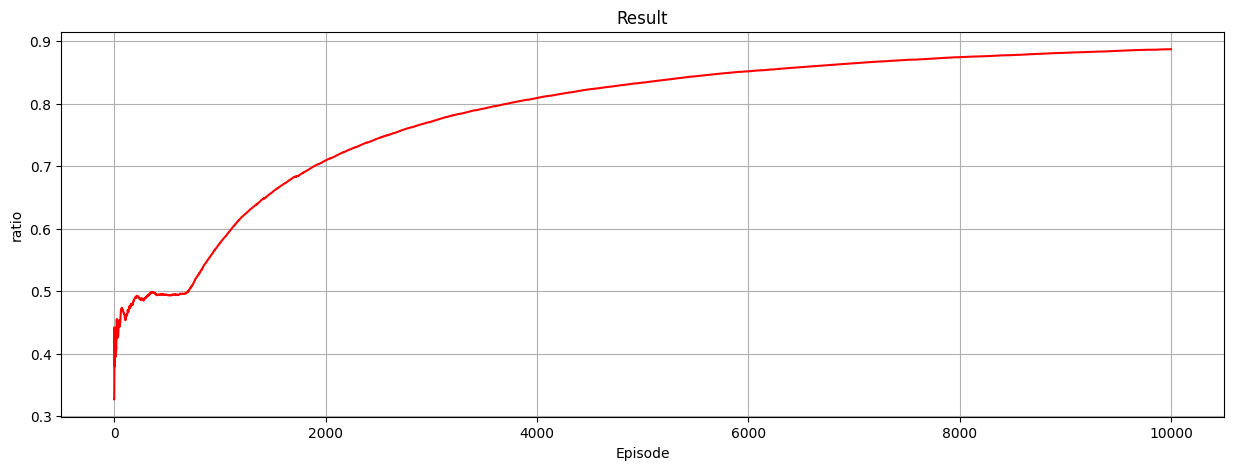

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
for i_episode in range(num_episodes):
    # Initialize the environment and state
    random.seed(i_episode)
    sum_reward = 0
    confusion_matrix = np.zeros((2,2), dtype=int)

    initial_state = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action = select_action(state)

        # print(action)
        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["matrix_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1
        # print(info)

        # to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        # optimize the model
        optimize_model()

        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    # episode_rewards.append(sum_reward)
    base = confusion_matrix[1, 1] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[1, 1] / base if base != 0 else 0
    )
    # print(i_episode)
    if i_episode > 0 and i_episode % 10 == 0:
        plot_graph(episode_precision)

# complete the episode
plot_graph(episode_precision, show_result=True)
torch.save(policy_net.state_dict(), "re_01_dqn.pth")  # save the model

train_env.close()

952 78745 8581 395 6799
953 78817 8593 395 6802
954 78818 8593 395 6802
955 78988 8613 395 6817
956 79051 8619 396 6829
957 79139 8630 396 6835
958 79209 8640 396 6840
959 79213 8642 397 6840
960 79313 8656 398 6844
961 79386 8659 398 6848
962 79473 8666 399 6855
963 79523 8673 399 6860
964 79763 8697 399 6881
965 79801 8700 399 6885
966 79908 8709 399 6898
967 79979 8718 399 6904
968 80011 8720 399 6908
969 80084 8727 399 6913
970 80197 8732 400 6921
971 80357 8754 403 6935
972 80740 8803 404 6975
973 80834 8814 404 6982
974 80867 8819 405 6984
975 81062 8841 406 7004
976 81128 8852 407 7008
977 81137 8852 407 7011
978 81210 8860 408 7014
979 81302 8866 410 7022
980 81339 8870 410 7025
981 81363 8873 410 7026
982 81541 8891 411 7032
983 81553 8891 411 7033
984 81574 8894 411 7037
985 81621 8904 412 7042
986 81648 8909 412 7044
987 81684 8913 413 7044
988 81751 8922 413 7047
989 81838 8932 413 7052
990 81886 8936 413 7057
991 81898 8940 413 7061
992 82054 8956 413 7072
993 82077 8958 4

<Figure size 640x480 with 0 Axes>

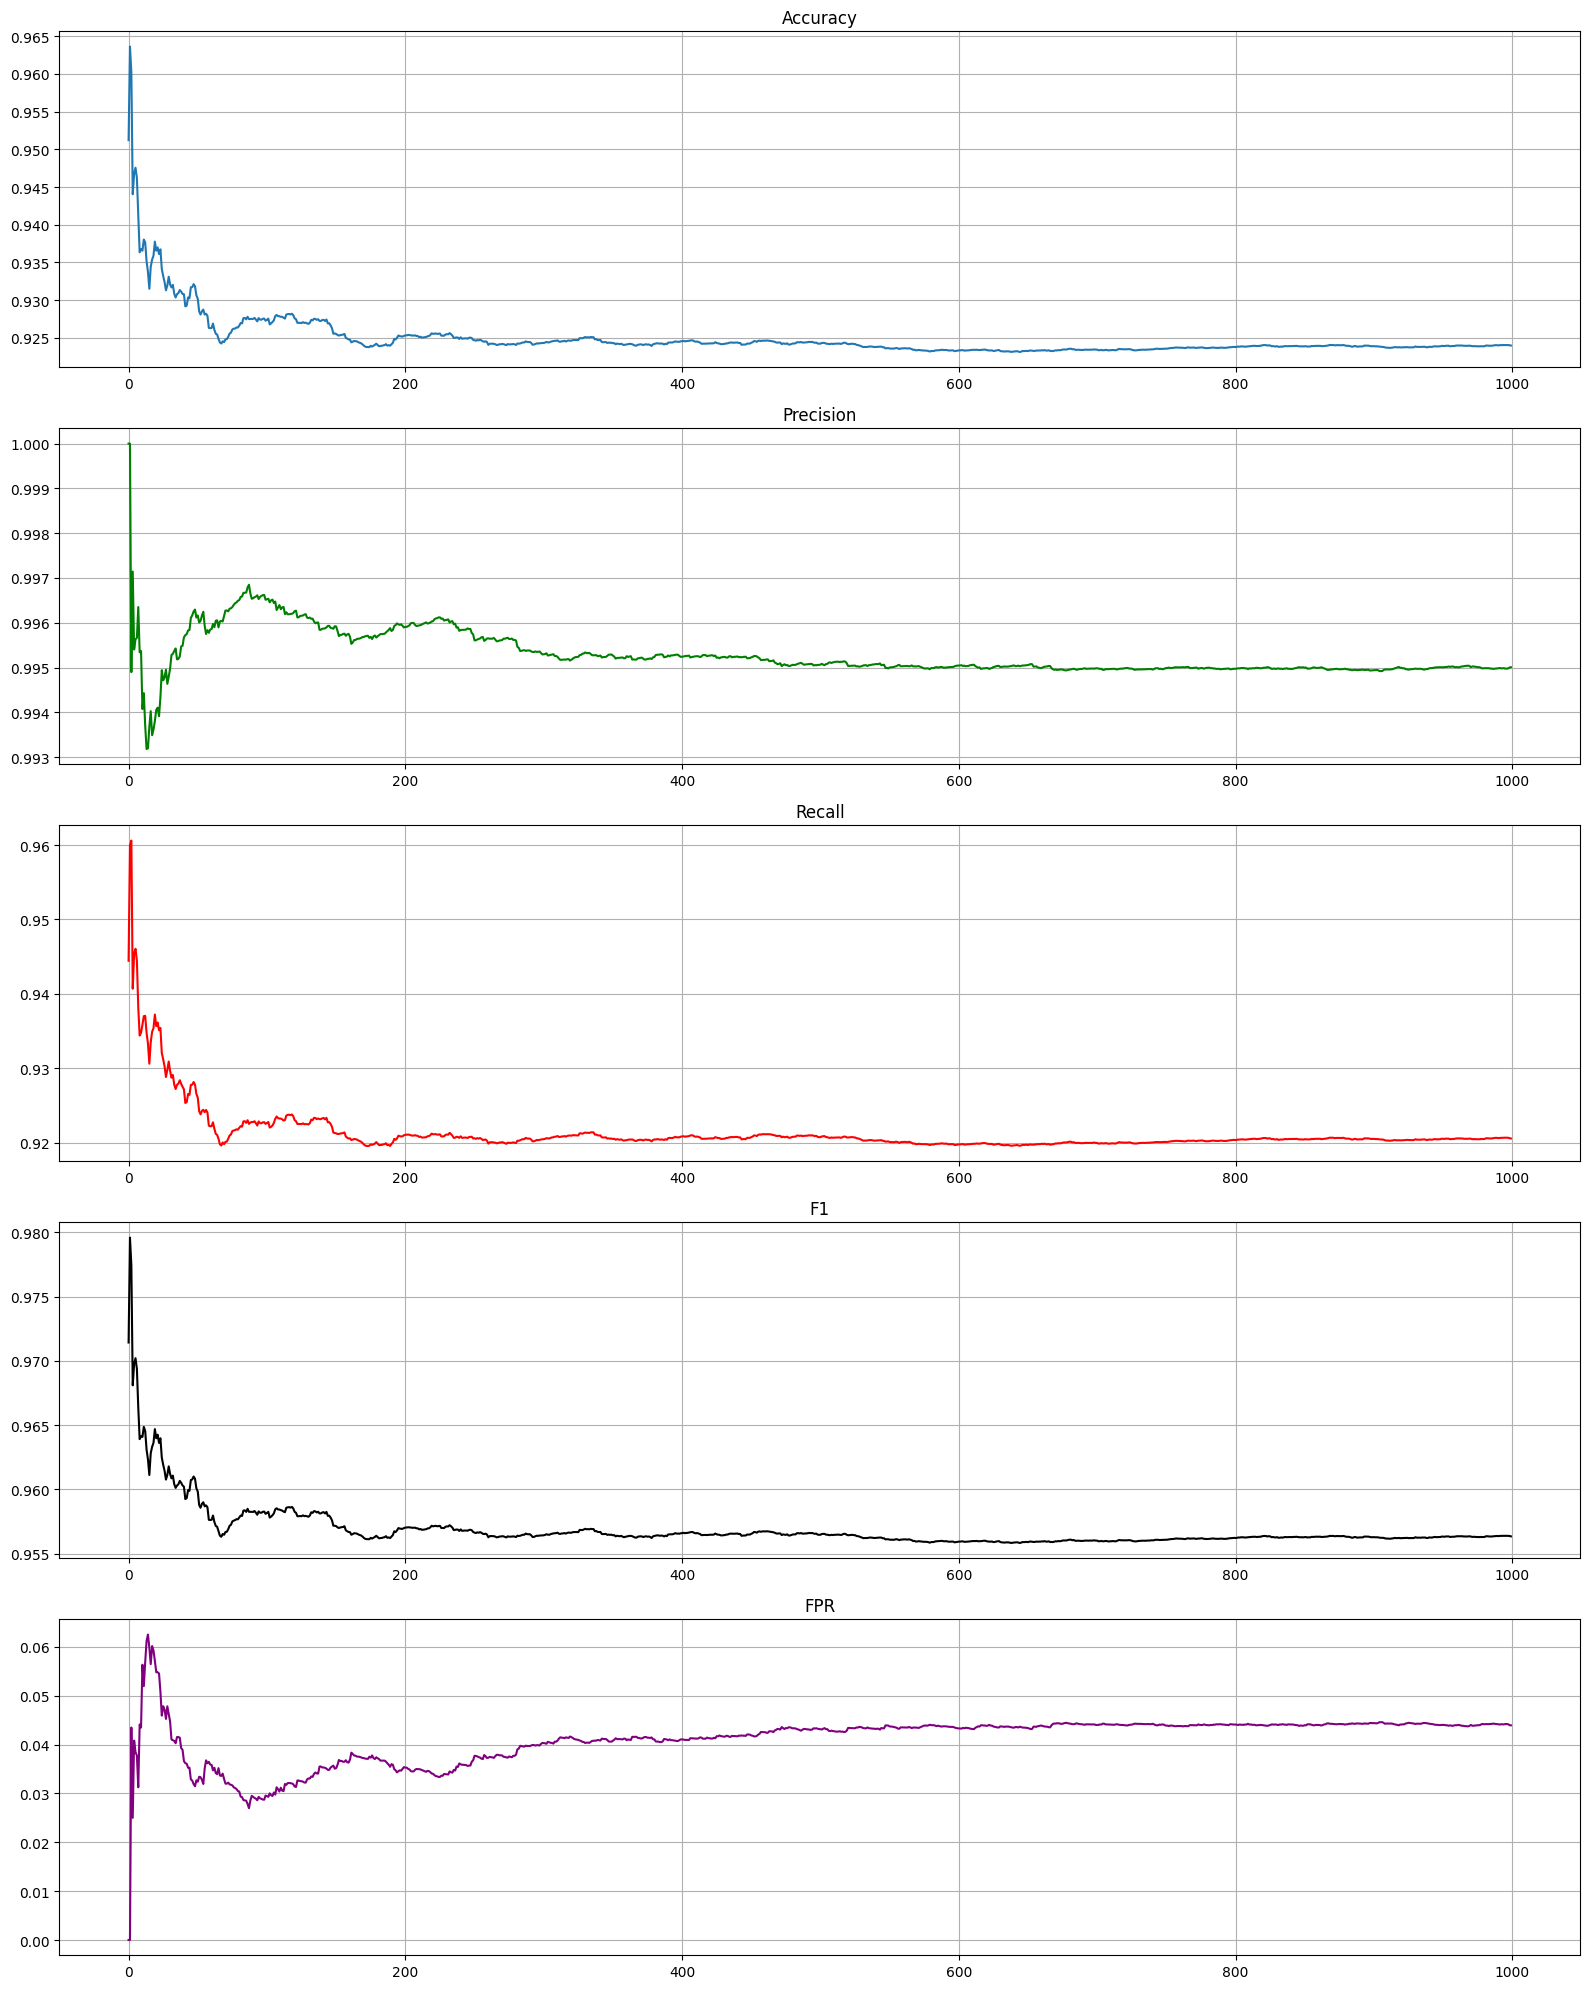

<Figure size 640x480 with 0 Axes>

 accuracy: 0.9239531089491813
precision: 0.9950075788561942
  recall : 0.9205760904649014
    f1   : 0.9563457880709705
   fpr   : 0.043929289721604745


<Figure size 640x480 with 0 Axes>

In [19]:
MODEL_PATH = "re_01_dqn.pth"

# load the model
trained_network = DQNetwork(n_inputs=n_inputs, n_outputs=n_actions).to(device)
trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(1000):
    random.seed(i_loop)
    test_raw_state = test_env.reset()
    test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            test_action = trained_network(test_state).max(1).indices.view(1, 1)

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["matrix_position"]
        confusion_array[index[0], index[1]] += 1

        # print(index)

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[1, 1]
    tn = confusion_array[0, 0]
    fp = confusion_array[1, 0]
    fn = confusion_array[0, 1]
    print(i_loop + 1, tp, tn, fp, fn)

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)
    # print(accuracy, precision, recall, f1, fpr)

    

    if i_loop % 50 == 0:
        plot_metrics(metrics_dictionary)

# plot metrics
plot_metrics(metrics_dictionary, show_result=True)
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")

In [15]:
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")

 accuracy: 0.8841923983322255
precision: 0.9809849991407037
  recall : 0.8892758977554722
    f1   : 0.9328819495111629
   fpr   : 0.16424557310995652


In [16]:
confusion_matrix

array([[6, 0],
       [1, 1]])